In [267]:
import numpy as np
import matplotlib.pyplot as plt

In [268]:
np.random.seed(1000)
A=np.random.randn(1000,10)
xbar=[]
for i in range(1,11):
  if i%2==0:
    xi = np.random.uniform(low = i, high = (i+1))
    xbar.append(xi)
  else:
    xi = np.random.uniform(low = -(i+1), high = -i)  
    xbar.append(xi)
xbar=np.array(xbar).reshape(10,1)
eps=np.random.randn(1000,1)
y=np.matmul(A,xbar) + eps

In [269]:
len(eps)

1000

In [270]:
len(xbar)

10

$ \huge{1.}$ \
\
The code is implemented below:

In [271]:
def evalf(x,n):
  assert type(x) is np.ndarray and len(x) == n
  f_val = 0.5*(np.linalg.norm(np.matmul(A,x) - y))**2
  return f_val  

In [272]:
def evalg(x, n):
  assert type(x) is np.ndarray and len(x) == n
  grad = np.matmul(A.T, np.matmul(A, x) - y)
  return grad

In [273]:
def evalh(x,n):
  assert type(x) is np.ndarray and len(x) == n
  hes =  np.matmul(A.T,A) #gradient of gradient of f
  return hes

$ \huge{2.}$ \
\
The code is implemented below:

In [274]:
BACKTRACKING_LINE_SEARCH = 1

In [275]:
def compute_steplength_backtracking_scaled_direction(n,x, gradf, direction, alpha_start, rho, gamma):
  assert type(x) is np.ndarray and len(x) == n 
  assert type(gradf) is np.ndarray and len(gradf) == n  
  assert type(direction) is np.ndarray and len(gradf) == n
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  alpha = alpha_start
  while evalf(x+alpha*direction,n) > (evalf(x,n) + gamma*alpha*np.matmul(gradf.T,direction)):
    alpha=rho*alpha

  return alpha

In [276]:
def find_minimizer_Newton(start_x, n, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray and len(start_x) == n
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  x_array= []
  while (np.linalg.norm(g_x) > tol):
    D_k = np.linalg.inv(evalh(x, n))
    p_k = -np.matmul(D_k,g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(n,x, g_x,p_k, alpha_start, rho, gamma)
    else:
      raise ValueError('Line search type unknown. Please check!') 

    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x)))
    x_array.append(x)
    k += 1
    g_x = evalg(x, n)

  return x,  k, x_array, evalf(x,n)

In [277]:
from timeit import default_timer as timer
import math
from tabulate import tabulate

In [278]:
my_start_x =np.zeros((10, 1))
n = len(my_start_x)
my_tol= 1e-4
alpha = 0.99
rho = 0.5
gamma = 0.5

time_start = timer()
x, k, x_array,f_value = find_minimizer_Newton(my_start_x, n, my_tol, BACKTRACKING_LINE_SEARCH, 0.99 , 0.5, 0.5)
time_end = timer()

x_val_n=[]
f_val_n=[]

for i in range(k-1):
  x_val_n.append(math.log(np.linalg.norm(x_array[i] - x)))
  f_val_n.append(math.log(abs(evalf(x_array[i],n) - evalf(x,n))))
  
table = []
cols = ["x*", "Function value at x*", "Number of iterations", "xbar", "Function value at xbar", "Time taken"]
table.append(cols)
table.append([x, f_value, k, xbar,evalf(xbar,n), time_end - time_start])

print(tabulate(table, headers = 'firstrow'))

x*                 Function value at x*    Number of iterations  xbar               Function value at xbar    Time taken
---------------  ----------------------  ----------------------  ---------------  ------------------------  ------------
[[-1.04982253]                  505.647                       5  [[-1.06258705]                    509.099    0.00572685
 [ 2.95189743]                                                    [ 2.94307072]
 [-3.34298192]                                                    [-3.34150552]
 [ 4.60956007]                                                    [ 4.58252615]
 [-5.71176195]                                                    [-5.75947573]
 [ 6.89877618]                                                    [ 6.93512469]
 [-7.62879358]                                                    [-7.61893094]
 [ 8.16821112]                                                    [ 8.16818187]
 [-9.22221199]                                                    [-9.2179964

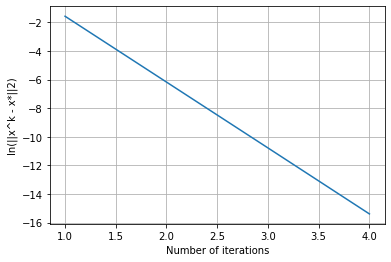

In [279]:
l=len(x_val_n)
plt.plot([i+1 for i in np.arange(l)], x_val_n)
plt.xlabel('Number of iterations')
plt.ylabel('ln(||x^k - x*||2)')
plt.grid()
plt.show()


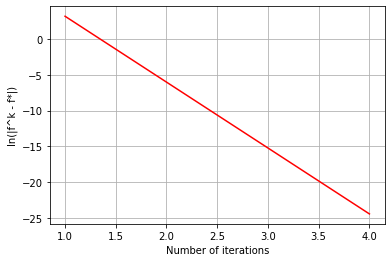

In [280]:
m=len(f_val_n)
plt.plot([i+1 for i in np.arange(m)], f_val_n,color='red')
plt.xlabel('Number of iterations')
plt.ylabel('ln(|f^k - f*|)')
plt.grid()
plt.show()

**Observations:** From the above plots, we can see that we have **Q-linear type convergence** rate for both the iterates and objective function values. \
The nature of the plots after taking $log$ tells us that **$r$** belongs in **$(0,1)$**, hence **Q-linear** type convergence.

$ \huge{3.}$ \
\
The code is implemented below:

In [281]:
def find_minimizer_BFGS(start_x, n, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray and len(start_x) == n 
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n)
  I = np.identity(n)
  B_k = (1/8)*I

  #initialization for backtracking line search
  if line_search_type == BACKTRACKING_LINE_SEARCH:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  x_array = []
  while (np.linalg.norm(g_x) > tol):
    p_k = -np.matmul(B_k, g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(n,x, g_x,p_k, alpha_start, rho, gamma)
    else:
      raise ValueError('Line search type unknown. Please check!')

    x_prev = x
    s_k = np.multiply(step_length,p_k)  
    x = np.add(x, s_k)
    y_k = evalg(x,n)-evalg(x_prev,n)

    u_k = 1/(np.matmul(y_k.T,s_k))
    a_1 = np.subtract(I , u_k*np.matmul(s_k,y_k.T))
    a_2 = np.subtract(I , u_k*np.matmul(y_k, s_k.T))
    B_k = np.matmul(np.matmul(a_1,B_k),a_2) + u_k*np.matmul(s_k,s_k.T)

    k += 1
    g_x = evalg(x,n) 
    x_array.append(x)
    
  return x, k, x_array, evalf(x,n)

In [282]:
my_start_x =np.zeros((10, 1))
my_tol= 1e-4
n = len(my_start_x)
alpha = 0.99
rho = 0.5
gamma = 0.5

time_start_bfgs = timer()
x1, k1, x_array, f_val_bfgs = find_minimizer_BFGS(my_start_x, n, my_tol, BACKTRACKING_LINE_SEARCH, 0.99, 0.5, 0.5)
time_end_bfgs = timer()

x_val_b=[]
f_val_b=[]
for i in range(k1-1):
  x_val_b.append(math.log(np.linalg.norm(x_array[i] - x)))
  f_val_b.append(math.log(abs(evalf(x_array[i],n) - evalf(x,n))))

table1= []
cols1 = ["x*", "Function value at x*", "Number of iterations", "xbar", "Function value at xbar", "Time taken"]
table1.append(cols1)
table1.append([x1, f_val_bfgs, k1, xbar,evalf(xbar,n), time_end_bfgs - time_start_bfgs])
print(tabulate(table1, headers = 'firstrow'))

x*                 Function value at x*    Number of iterations  xbar               Function value at xbar    Time taken
---------------  ----------------------  ----------------------  ---------------  ------------------------  ------------
[[-1.04982253]                  505.647                      17  [[-1.06258705]                    509.099      0.010835
 [ 2.95189743]                                                    [ 2.94307072]
 [-3.34298192]                                                    [-3.34150552]
 [ 4.60956007]                                                    [ 4.58252615]
 [-5.71176195]                                                    [-5.75947573]
 [ 6.89877618]                                                    [ 6.93512469]
 [-7.62879358]                                                    [-7.61893094]
 [ 8.16821111]                                                    [ 8.16818187]
 [-9.22221199]                                                    [-9.2179964

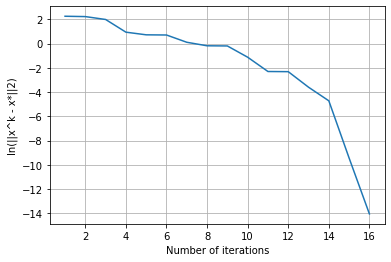

In [283]:
l=len(x_val_b)
plt.plot([i+1 for i in np.arange(l)], x_val_b)
plt.xlabel('Number of iterations')
plt.ylabel('ln(||x^k - x*||2)')
plt.grid()
plt.show()

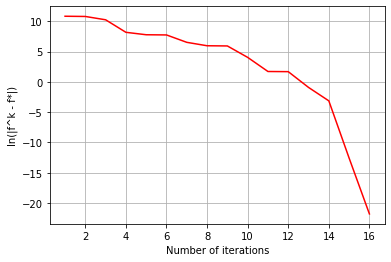

In [284]:
m=len(f_val_b)
plt.plot([i+1 for i in np.arange(m)], f_val_b, color = "red")
plt.xlabel('Number of iterations')
plt.ylabel('ln(|f^k - f*|)')
plt.grid()
plt.show()

**Observations:** From the above plots, we can see that we have **Q-linear type convergence** rate for both the iterates and objective function values. \
The nature of the plots after taking $log$ tells us that **$r$** belongs in **$(0,1)$**, hence **Q-linear** type convergence.

$ \huge{4.}$

In [285]:
print(tabulate(table, headers = 'firstrow'))

x*                 Function value at x*    Number of iterations  xbar               Function value at xbar    Time taken
---------------  ----------------------  ----------------------  ---------------  ------------------------  ------------
[[-1.04982253]                  505.647                       5  [[-1.06258705]                    509.099    0.00572685
 [ 2.95189743]                                                    [ 2.94307072]
 [-3.34298192]                                                    [-3.34150552]
 [ 4.60956007]                                                    [ 4.58252615]
 [-5.71176195]                                                    [-5.75947573]
 [ 6.89877618]                                                    [ 6.93512469]
 [-7.62879358]                                                    [-7.61893094]
 [ 8.16821112]                                                    [ 8.16818187]
 [-9.22221199]                                                    [-9.2179964

In [286]:
print(tabulate(table1, headers = 'firstrow'))

x*                 Function value at x*    Number of iterations  xbar               Function value at xbar    Time taken
---------------  ----------------------  ----------------------  ---------------  ------------------------  ------------
[[-1.04982253]                  505.647                      17  [[-1.06258705]                    509.099      0.010835
 [ 2.95189743]                                                    [ 2.94307072]
 [-3.34298192]                                                    [-3.34150552]
 [ 4.60956007]                                                    [ 4.58252615]
 [-5.71176195]                                                    [-5.75947573]
 [ 6.89877618]                                                    [ 6.93512469]
 [-7.62879358]                                                    [-7.61893094]
 [ 8.16821111]                                                    [ 8.16818187]
 [-9.22221199]                                                    [-9.2179964

In [287]:
time = []
cols = ["Time taken by Newton's Method", "Time taken by BFGS Method"]
time.append(cols)
time.append([time_end - time_start, time_end_bfgs - time_start_bfgs])
print(tabulate(time, headers = "firstrow")) 

  Time taken by Newton's Method    Time taken by BFGS Method
-------------------------------  ---------------------------
                     0.00572685                     0.010835


**Observations:** We note that the **optimal value of the objective function obtained via Newton's Method and BFGS method is the same**. The function value through both the methods at the points xbar is also the same. \
The **main point of difference that stands out is the number of iterations** needed by both the methods to reach the optimizer. While the **BFGS method required 17 iterations**, it took **Newton's method only 5 iterations** to perform the same task. Consequently, the **time taken by Newton's method to reach the optimizer is found to be lesser than that taken by the BFGS method**. This tells us that for the given problem of OLSR Newton's method is more efficient than the BFGS method.